In [1]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats.stats import pearsonr

In [2]:
# CSVs for clean up 
cln_play_f = 'sources/nba_stats.csv'
cln_sal_f = 'sources/players_salaries.csv'
cln_team_f = 'sources/Team_Stats_20_21.csv'

In [3]:
cln_play_df = pd.read_csv(cln_play_f)
cln_sal_df = pd.read_csv(cln_sal_f)
cln_team_df = pd.read_csv(cln_team_f)

# Clean up of nba_stats.csv

In [4]:
# Inspect column names in order to look for columns to drop
# for col in cln_play_df.columns:
#     print(col)

In [5]:
#Drop Unnamed columns
cln_play01_df =cln_play_df.drop(['Unnamed: 19','Unnamed: 24'],axis = 1)

In [6]:
#Create new Dataframe that drops duplicates and keeps the first row.
# In this CSV, in the Tm column, the first duplicate will have a value of "TOT".
# This is the average of that player's stats.
cln_play02_df = cln_play01_df.drop_duplicates(subset='Player',keep='first', inplace=False, ignore_index=False)

## The clean DataFrame is named 'cln_play02_df'

# Clean up of players_salaries.csv

In [7]:
cln_sal_df

,Name,Position,Team,Age,Height,Height_i,Weight,College,Salary,Points,Rebounds,Assists
0,Juhann Begarin,SG,Boston Celtics,19,"6' 5""",6.50,185,NaN,NaN,NaN,NaN,NaN
1,Jaylen Brown,SG,Boston Celtics,24,"6' 6""",6.60,223,California,26758928.0,24.7,6.0,3.4
2,Kris Dunn,PG,Boston Celtics,27,"6' 3""",6.30,205,Providence,5005350.0,1.3,1.5,0.5
3,Carsen Edwards,PG,Boston Celtics,23,"5' 11""",5.11,200,Purdue,1782621.0,4.0,0.8,0.5
4,Tacko Fall,C,Boston Celtics,25,"7' 5""",7.50,311,UCF,NaN,2.5,2.7,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...
553,Juwan Morgan,SF,Utah Jazz,24,"6' 7""",6.70,232,Indiana,NaN,1.2,1.0,0.3
554,Royce O'Neale,PF,Utah Jazz,28,"6' 4""",6.40,226,Baylor,8800000.0,7.0,6.8,2.5
555,Olumiye Oni,SG,Utah Jazz,24,"6' 5""",6.50,206,Yale,1782621.0,NaN,NaN,NaN
556,Eric Paschall,F,Utah Jazz,24,"6' 6""",6.60,255,Villanova,1782621.0,9.5,3.2,1.3


In [8]:
#Drop Rows without Salaries
cln_sal01_df=cln_sal_df.dropna(subset=['Salary'])
#cln_sal01_df

## The clean DataFrame is named 'cln_sal01_df'

In [9]:
#Merge the cleaned DataFrames based on the nba_stats.csv and players_salaries.csv
cln_m01_df = cln_play02_df.merge(cln_sal01_df,how ="inner", left_on ="Player", right_on ="Name")

In [10]:
#Create Salary bins for examining groups of NBA salaries
salary_bins = [0, 999999, 8999999, 17999999, 26999999, 35999999, 44999999, 55000000]
bin_names = ["00 to 01 mil", "01 to 09 mil", "09 to 18 mil", "18 to 27 mil",
            "27 to 36 mil", "36 to 45 mil", "Over 45 mil"]
cln_m01_df["Salary Categories"] = pd.cut(cln_m01_df["Salary"], bins = salary_bins, labels= bin_names, include_lowest = True)
#Groupby group players into their bins by salary
cln_m01_df = cln_m01_df.sort_values(by=['Salary Categories'])
#cln_m01_df

In [11]:
# Merge Team_Stats Data with DataFrame that includes salary bins
cln_t01_df = cln_m01_df.merge(cln_team_df,how ="inner", left_on ="Team", right_on ="Team_Name")
#cln_t01_df

In [12]:
# Put Salaries into a list for for loop (and later for plot labels)
salary_names = cln_t01_df['Salary Categories'].unique()
salary_names = salary_names.tolist()
#salary_names

In [13]:
# Create empty list to fill with PER data and salary buckets (for plotting)
boxplot_data = []


#loop
for name in salary_names:
    boxplot_values = cln_t01_df.loc[cln_t01_df['Salary Categories']==name,'PER']
    boxplot_data.append(boxplot_values)
#boxplot_data 

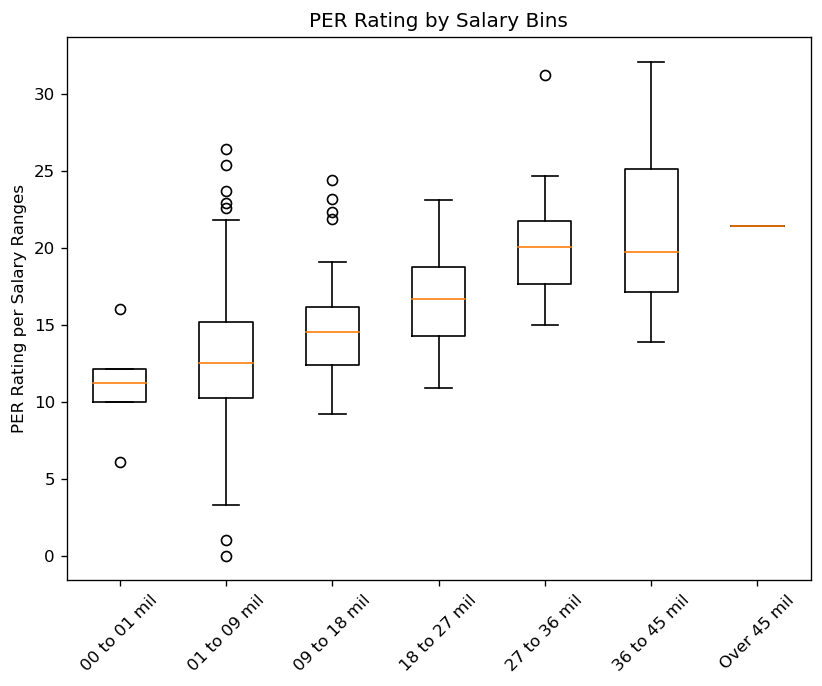

In [22]:
# Generate a box plot

fig1, axl = plt.subplots(figsize=(8, 6), dpi=120)

axl.set_ylabel('PER Rating per Salary Ranges')
axl.boxplot(boxplot_data, labels=salary_names )
plt.xticks(rotation =45)
axl.set_facecolor('white')
plt.title('PER Rating by Salary Bins')
plt.savefig('outputs/Salary_BoxPlots.png')

plt.show()

In [15]:
per_team_PER = cln_t01_df.groupby(["Team_Name"]).mean()["PER"]
per_team_winperc = cln_t01_df.groupby(["Team_Name"]).mean()["Team_WL_Percent"]
per_avg_salary = cln_t01_df.groupby(["Team_Name"]).sum()["Salary"]

In [16]:
team_per_summary = pd.DataFrame({'Win Percentage': per_team_winperc,
                                 'Team Per Rating':per_team_PER,
                                'Total Team Salary':per_avg_salary
                                })
#team_per_summary

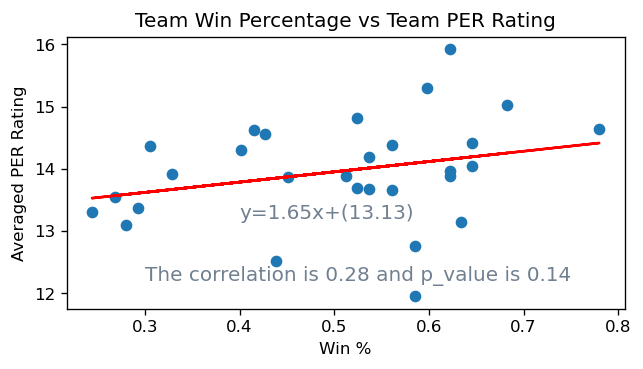

In [24]:
#Scatterplot for Team win percentage vs the average PER rating of the team
plt.figure(figsize=(6, 3), dpi=120)

x = team_per_summary['Win Percentage']
y = team_per_summary['Team Per Rating']


plt.scatter(x,y)

z = np.polyfit(x,y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),color='red')
axl.set_facecolor('white')


plt.title('Team Win Percentage vs Team PER Rating')
plt.xlabel('Win %')
plt.ylabel('Averaged PER Rating')
ptext =("y=%.2fx+(%.2f)"%(z[0],z[1]))

# correlation coefficient and p_value for win percentage vs team PER
corr=round(st.pearsonr(x,y)[0],2)
p_value= round(pearsonr(x,y)[1],2)

#Annotations
plt.annotate(ptext,(0.4,13.2),fontsize=12,color="slategray")
plt.annotate(f'The correlation is {corr} and p_value is {p_value}',(0.3,12.2),fontsize=12,color="slategray")

plt.savefig('outputs/Salary_vs_PER.png')


plt.show()

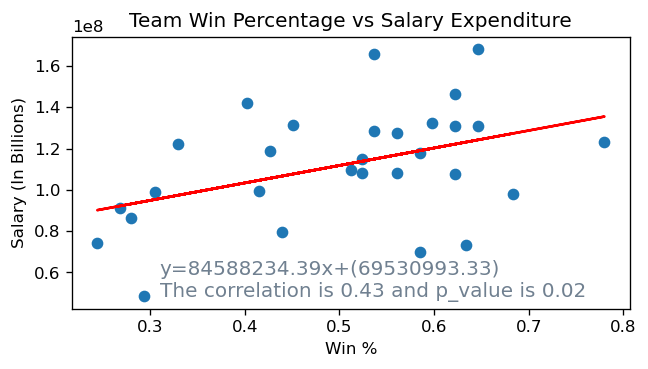

In [25]:
# #Scatterplot for Team Win Percentage vs Salary Expenditure
plt.figure(figsize=(6, 3), dpi=120)
x= team_per_summary['Win Percentage']
y= team_per_summary['Total Team Salary']


plt.scatter(x,y)

z = np.polyfit(x,y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),color='red')
axl.set_facecolor('white')

# correlation coefficient and p_value for win percentage vs Salary Expenditure
corr=round(st.pearsonr(x,y)[0],2)
p_value= round(pearsonr(x,y)[1],2)

#Graph and axis titles
plt.title('Team Win Percentage vs Salary Expenditure') 
plt.xlabel('Win %')
plt.ylabel('Salary (In Billions)')
ptext =("y=%.2fx+(%.2f)"%(z[0],z[1]))

#Annotations
plt.annotate(ptext,xy=(0.31,59000000),fontsize=12,color="slategray")
plt.annotate(f'The correlation is {corr} and p_value is {p_value}',(0.31,48000000),fontsize=12,color="slategray")




plt.savefig('outputs/Salary_vs_Wins.png')

plt.show()